# Рекомендация продукта

У нас есть датасет от archive.ics.uci.edu

В датасете описаны данные товаров, на основе которых мы должны создать систему рекомендаций.

Описание датасета:
<pre>
- InvoiceNo    - уникальный номер транзакции
- StockCode    - код продукта
- Description  - описание продукта
- Quantity     - количество каждого продукта в транзакции
- InvoiceDate  - дата и время создания транзакции
- CustomerID   - ID клиента
- Country      - страна
</pre>

# Анализ данных

## Импорт бибоиотек

In [111]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import warnings;
warnings.filterwarnings('ignore')

## Загрузка и просмотр данных

In [112]:
df = pd.read_excel(r"C:\Users\Dmitri\Downloads\Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [113]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Адаптация данных

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [115]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [116]:
df.dropna(inplace=True)

In [117]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<div style="border:solid #81d8e6 2px; padding: 10px">
Мы удалили все пропуски, чтобы при работе с ID покупателями не возникало ошибок. Заменить данные мы не можем, поскольку их невозможно получить иным путём.
</div>

In [118]:
data = df.sample(100000)

<div style="border:solid #81d8e6 2px; padding: 10px">
Для начала возьмём меньшую выборку, чтобы проверить работоспособность кода.
</div>

In [119]:
data['StockCode']= data['StockCode'].astype(str)

<div style="border:solid #81d8e6 2px; padding: 10px">
Изменяем тип данных в столбце с кодом продукта для того, чтобы затем проще с ними работать.
</div>

## Разделение и подготовка выборок

In [120]:
data_train, data_valid = train_test_split(data, train_size=0.8, test_size=0.2, random_state=12345)

<div style="border:solid #81d8e6 2px; padding: 10px">
Мы разделили выборки, чтобы проверить работоспособность нашей модели с новыми данными. теперь создадим список покупок каждого потребителя.
</div>

In [121]:
purchases_train = []

customers_train = data_train['CustomerID'].values
for i in tqdm(customers_train):
    temp = data_train[data_train["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [00:46<00:00, 1730.36it/s]


In [122]:
data_train.query('CustomerID==16029.0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
252251,559098,21166,COOK WITH WINE METAL SIGN,192,2011-07-06 11:02:00,1.85,16029.0,United Kingdom
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029.0,United Kingdom
304097,563562,85099B,JUMBO BAG RED RETROSPOT,100,2011-08-17 14:02:00,1.74,16029.0,United Kingdom
384009,570097,22570,FELTCRAFT CUSHION RABBIT,240,2011-10-07 12:05:00,3.39,16029.0,United Kingdom
121097,546734,22930,BAKING MOULD HEART MILK CHOCOLATE,96,2011-03-16 11:49:00,2.10,16029.0,United Kingdom
32668,539101,21166,COOK WITH WINE METAL SIGN,144,2010-12-16 10:35:00,1.53,16029.0,United Kingdom
348500,567455,22666,RECIPE BOX PANTRY YELLOW DESIGN,12,2011-09-20 12:14:00,2.55,16029.0,United Kingdom
56653,541105,85099F,JUMBO BAG STRAWBERRY,200,2011-01-13 14:34:00,1.65,16029.0,United Kingdom
390542,C570556,22149,FELTCRAFT 6 FLOWER FRIENDS,-600,2011-10-11 11:10:00,1.85,16029.0,United Kingdom
390503,C570552,21931,JUMBO STORAGE BAG SUKI,-100,2011-10-11 11:01:00,1.74,16029.0,United Kingdom


In [123]:
len(purchases_train[0])

12

<div style="border:solid #81d8e6 2px; padding: 10px">
Теперь проверяем правильность данных. Мы нашли покупки 1 покупателя в данных и 1 покупателя в списке покупок. Их количество совпадает. Аналогично делаем и с валидационной выборкой.
</div>

In [124]:
purchases_val = []

customers_val = data_valid['CustomerID'].values
for i in tqdm(customers_val):
    temp = data_valid[data_valid["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:09<00:00, 2102.46it/s]


In [125]:
data_valid.query('CustomerID==13816.0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
381357,569861,23292,SPACEBOY CHILDRENS CUP,8,2011-10-06 14:37:00,1.25,13816.0,Germany
381350,569861,84078A,SET/4 WHITE RETRO STORAGE CUBES,1,2011-10-06 14:37:00,39.95,13816.0,Germany


In [126]:
len(purchases_val[0])

10

# Обучение и работа с моделью

<div style="border:solid #81d8e6 2px; padding: 10px">
Обучаем модель.
</div>

In [127]:
model = Word2Vec(window = 15, sg = 1, hs = 0,
                 negative = 10,
                 alpha=0.04, min_alpha=0.0006,
                 seed = 14)

<div style="border:solid #81d8e6 2px; padding: 10px">
Создаём словарь и тренеруем модель.
</div>

In [128]:
model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(104607780, 105048160)

<div style="border:solid #81d8e6 2px; padding: 10px">
Закрепляем модель, так как больше обучать мы её не будем.
</div>

In [129]:
model.init_sims(replace=True)

In [130]:
print(model)

Word2Vec(vocab=3272, vector_size=100, alpha=0.04)


<div style="border:solid #81d8e6 2px; padding: 10px">
Создаём словарь векторов.
</div>

In [131]:
X = model.wv[model.wv.index_to_key]

X.shape

(3272, 100)

<div style="border:solid #81d8e6 2px; padding: 10px">
Мы уменьшаем эти стомерные вектора до двумерных
</div>

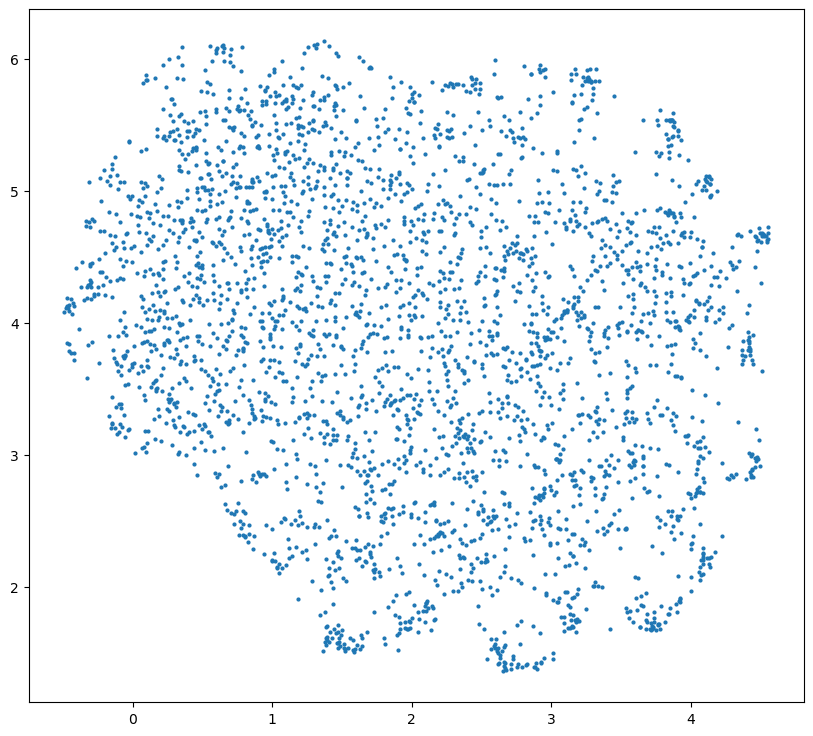

In [132]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=40, min_dist=0.0,
                              n_components=2, random_state=12345).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=4, cmap='Spectral')

# Работа со словарём

<div style="border:solid #81d8e6 2px; padding: 10px">
Теперь нужно создать словарь с номером товара и его описанием.
</div>

In [133]:
products = data_train[["StockCode", "Description"]]
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

<div style="border:solid #81d8e6 2px; padding: 10px">
Проверяем работу словаря
</div>

In [134]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

<div style="border:solid #81d8e6 2px; padding: 10px">
Создаём функцию, которая находит схожие покупки. Мы смотрим вектор покупки, ищем топ-5 (по умолчанию) схожих и выводим.
</div>

In [135]:
def offer(vector, n=5, show=False):
    simulars = model.wv.similar_by_vector(vector, topn=n+1)[1:]
    new_simulars = []
    for i in simulars:
        pair = (products_dict[i[0]][0], i[1])
        new_simulars.append(pair)
    if show==True:
        print('Most simular products are:')
        for i in new_simulars:
            print(i[0])
    return new_simulars   

In [136]:
offer(model.wv['84029E'], show=True)

Most simular products are:
THREE CANVAS LUGGAGE TAGS
CLASSICAL ROSE CANDLESTAND
CAKE STAND LOVEBIRD 2 TIER PINK
FELT TOADSTOOL  SMALL
SKULLS  WATER TRANSFER TATTOOS 


[('THREE CANVAS LUGGAGE TAGS', 0.4333089590072632),
 ('CLASSICAL ROSE CANDLESTAND', 0.42668798565864563),
 ('CAKE STAND LOVEBIRD 2 TIER PINK', 0.39954686164855957),
 ('FELT TOADSTOOL  SMALL', 0.39659053087234497),
 ('SKULLS  WATER TRANSFER TATTOOS ', 0.39386940002441406)]

<div style="border:solid #81d8e6 2px; padding: 10px">
В том случае, если мы хотим предложить пользователю товар исходя из его покупок, то нам нужно найти средний вектор его покупок.
</div>

In [137]:
def mean_purchase(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [138]:
len(purchases_val[0])

10

In [139]:
mean_purchase(purchases_val[0]).shape

(100,)

In [140]:
offer(mean_purchase(purchases_val[0]))

[('ALARM CLOCK BAKELIKE IVORY', 0.5523882508277893),
 ('STORAGE TIN VINTAGE LEAF', 0.5363788604736328),
 ('SET 6 PAPER TABLE LANTERN HEARTS ', 0.5126292109489441),
 ('SET OF 10 LED DOLLY LIGHTS', 0.5046722292900085),
 ('RIBBON REEL POLKADOTS ', 0.4970097243785858)]

In [141]:
offer(mean_purchase(purchases_val[0][-10:]))

[('ALARM CLOCK BAKELIKE IVORY', 0.5523882508277893),
 ('STORAGE TIN VINTAGE LEAF', 0.5363788604736328),
 ('SET 6 PAPER TABLE LANTERN HEARTS ', 0.5126292109489441),
 ('SET OF 10 LED DOLLY LIGHTS', 0.5046722292900085),
 ('RIBBON REEL POLKADOTS ', 0.4970097243785858)]

# Вывод

<div style="border:solid #81d8e6 2px; padding: 10px">
Мы создали модель, которая проанализировала данные магазина и научилась предсказывать возможные покупки относительно одной покупки или списка покупок пользователя. Для этого мы использовали функции: mean_purchase и offer. 
    
Цель достигнута.
</div>